# Loading External Catalog Data

This notebook demonstrates how to load lightcone data from external simulation suites
(**CosmoGrid** and **GowerStreet**) using the `ffi.io` loaders.

Both loaders return a `Catalog` object containing:
- `catalog.field` — a `SphericalDensity` PyTree (stacked HEALPix shells)
- `catalog.cosmology` — a `jax_cosmo.Cosmology` with the simulation's parameters

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import fwd_model_tools as ffi

ERROR:2026-02-12 22:03:41,648:jax._src.xla_bridge:491: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax/_src/xla_bridge.py", line 489, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__init__.py", line 285, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: CUDA_ERROR_UNKNOWN
/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax_cosmo/__init__.py:2: UserWarning: pkg_resour

## Loading CosmoGrid Data

CosmoGrid stores pre-computed lightcone shells as compressed `.npz` files.
Use `load_cosmogrid_lc()` to load them into a `Catalog`.

In [2]:
cosmogrid_path = Path("/home/wassim/Projects/NBody/Simulations/CosmoGrid/raw/cosmo_000001/run_0/")

cosmogrid_catalog = ffi.io.load_cosmogrid_lc(cosmogrid_path, max_shells=8, ud_nside=512)

print(f"Field shape:  {cosmogrid_catalog.field.shape}")
print(f"Field nside:  {cosmogrid_catalog.field.nside}")
print(f"Field status: {cosmogrid_catalog.field.status}")
print(f"Field unit:   {cosmogrid_catalog.field.unit}")

Field shape:  (8, 3145728)
Field nside:  512
Field status: FieldStatus.LIGHTCONE
Field unit:   DensityUnit.COUNTS


In [3]:
cosmo = cosmogrid_catalog.cosmology

print(f"Omega_c: {cosmo.Omega_c:.4f}")
print(f"Omega_b: {cosmo.Omega_b:.4f}")
print(f"h:       {cosmo.h:.4f}")
print(f"sigma8:  {cosmo.sigma8:.4f}")
print(f"n_s:     {cosmo.n_s:.4f}")
print(f"w0:      {cosmo.w0:.4f}")

Omega_c: 0.2538
Omega_b: 0.0450
h:       0.7300
sigma8:  0.9000
n_s:     0.9700
w0:      -1.1665


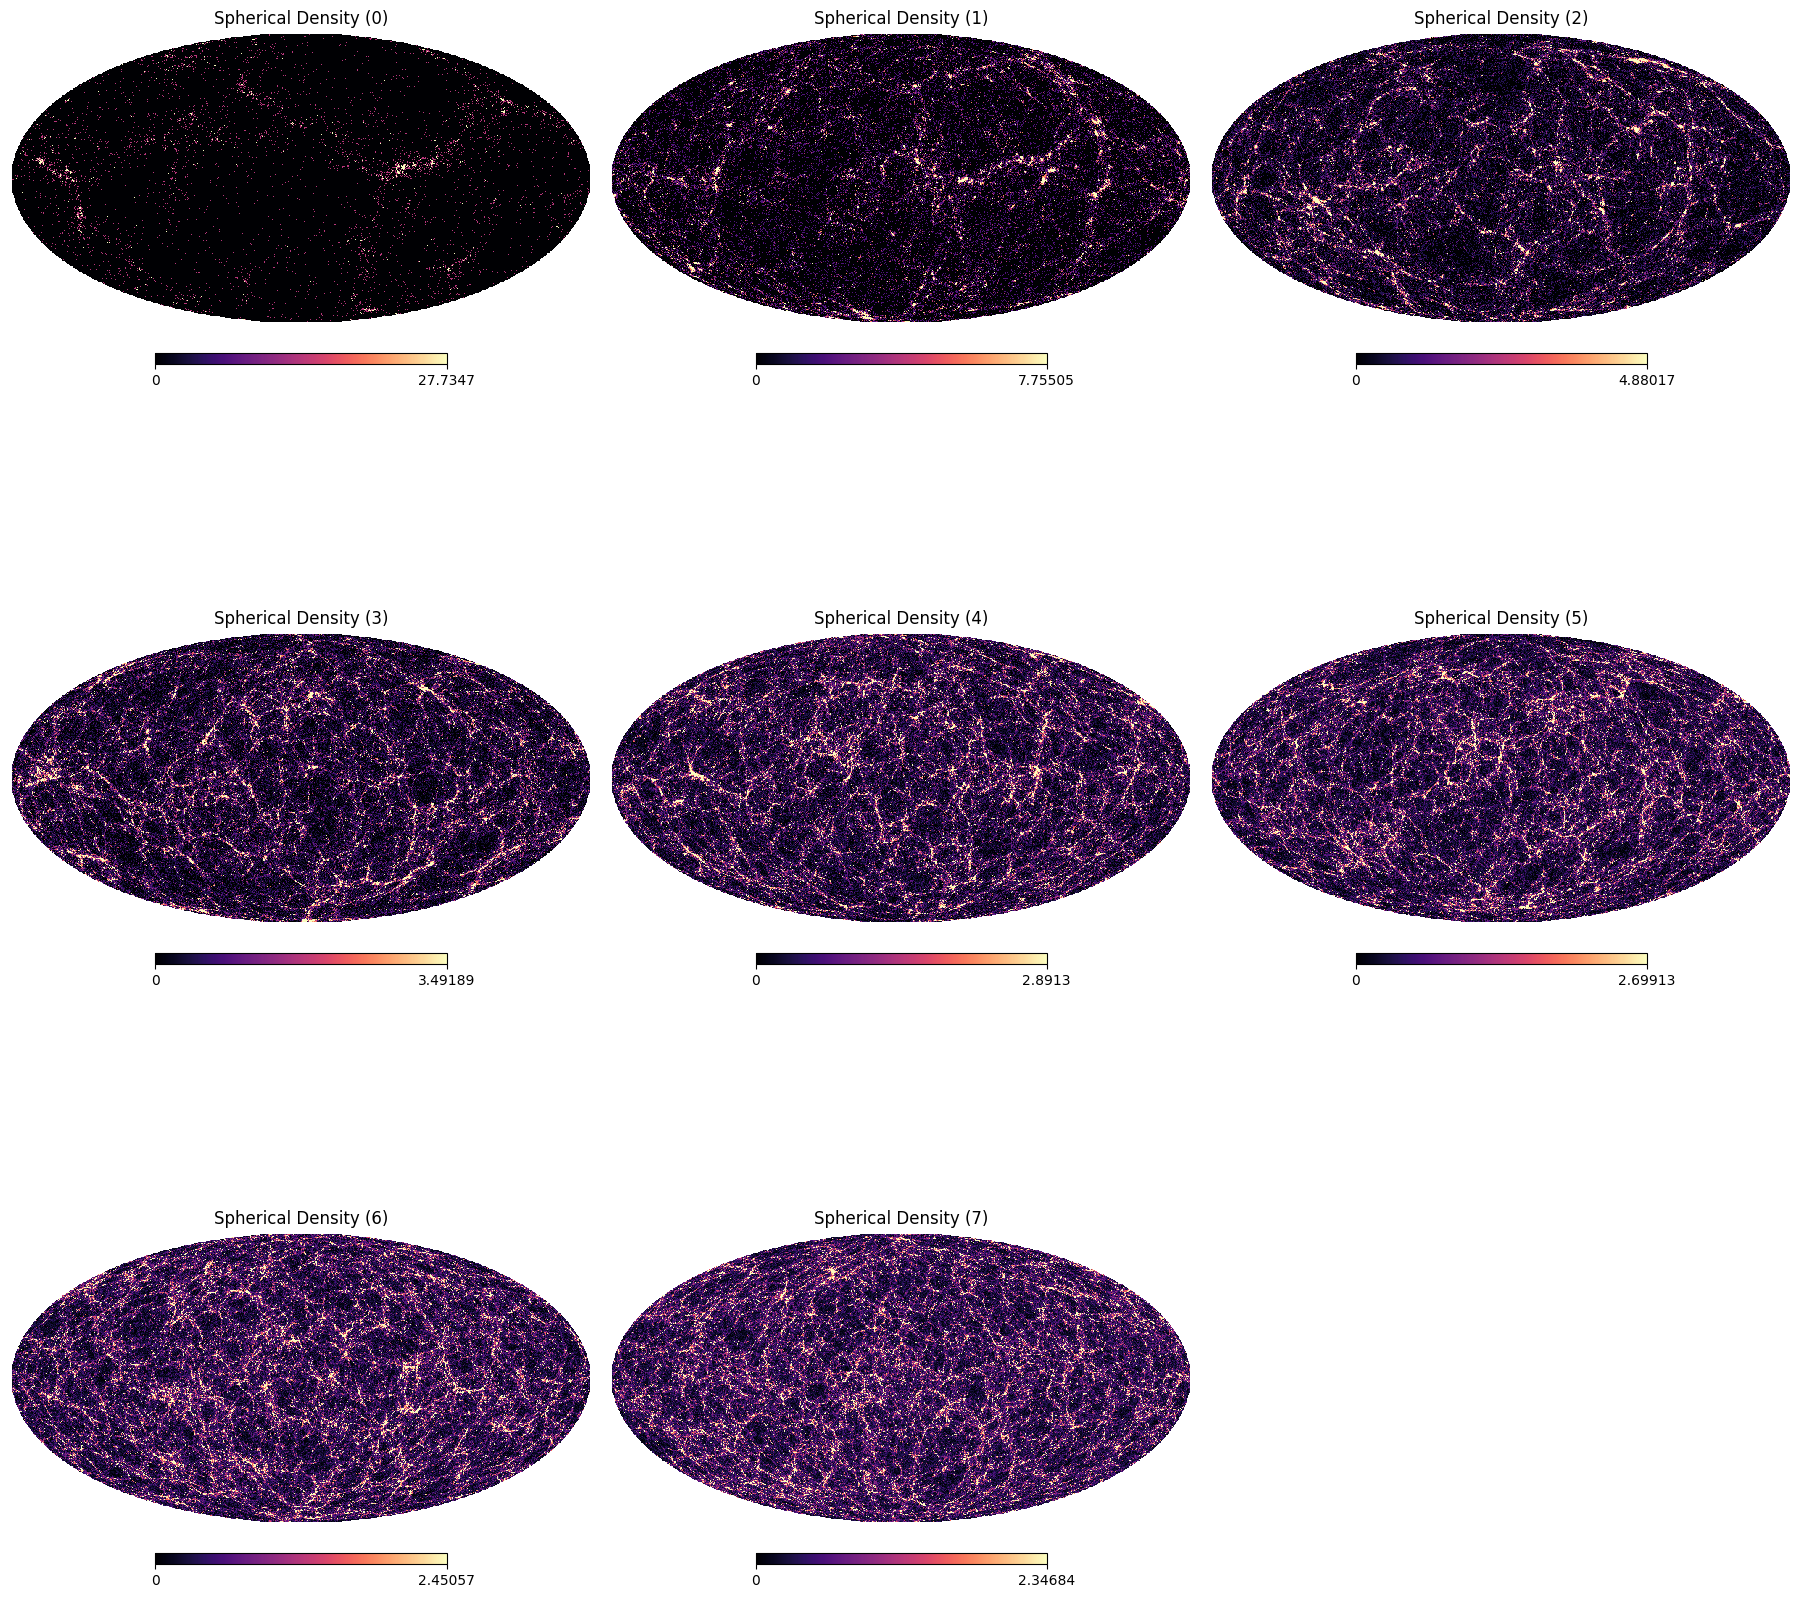

In [4]:
cosmogrid_catalog.field.to(ffi.DensityUnit.DENSITY).show()

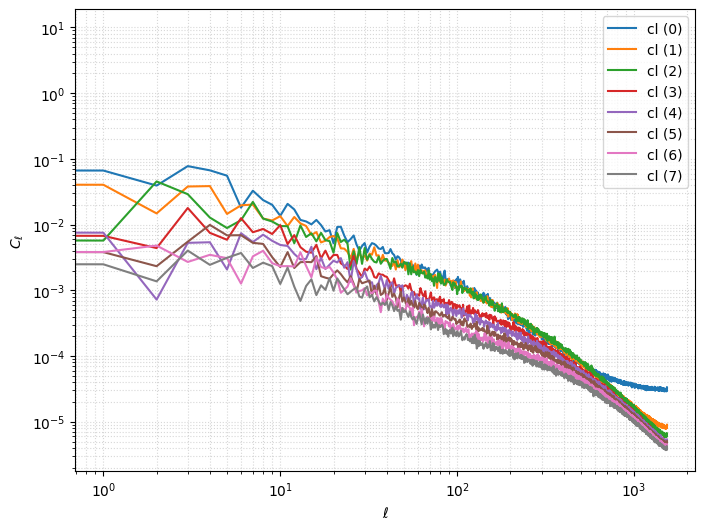

(<Figure size 800x600 with 1 Axes>,
 <Axes: xlabel='$\\ell$', ylabel='$C_\\ell$'>,
  <matplotlib.lines.Line2D at 0x7290435c2e50>])

In [5]:
cosmogrid_catalog.field.to(ffi.DensityUnit.DENSITY).angular_cl(method="healpy").show()

## Loading CosmoGrid Kappa Maps (Stage 3 Forecast)

We can also load projected kappa maps from CosmoGrid Stage 3 forecast runs.
These are stored in HDF5 format.

Stage 3 Field shape: (4, 3145728)
Stage 3 Field unit: ConvergenceUnit.DIMENSIONLESS


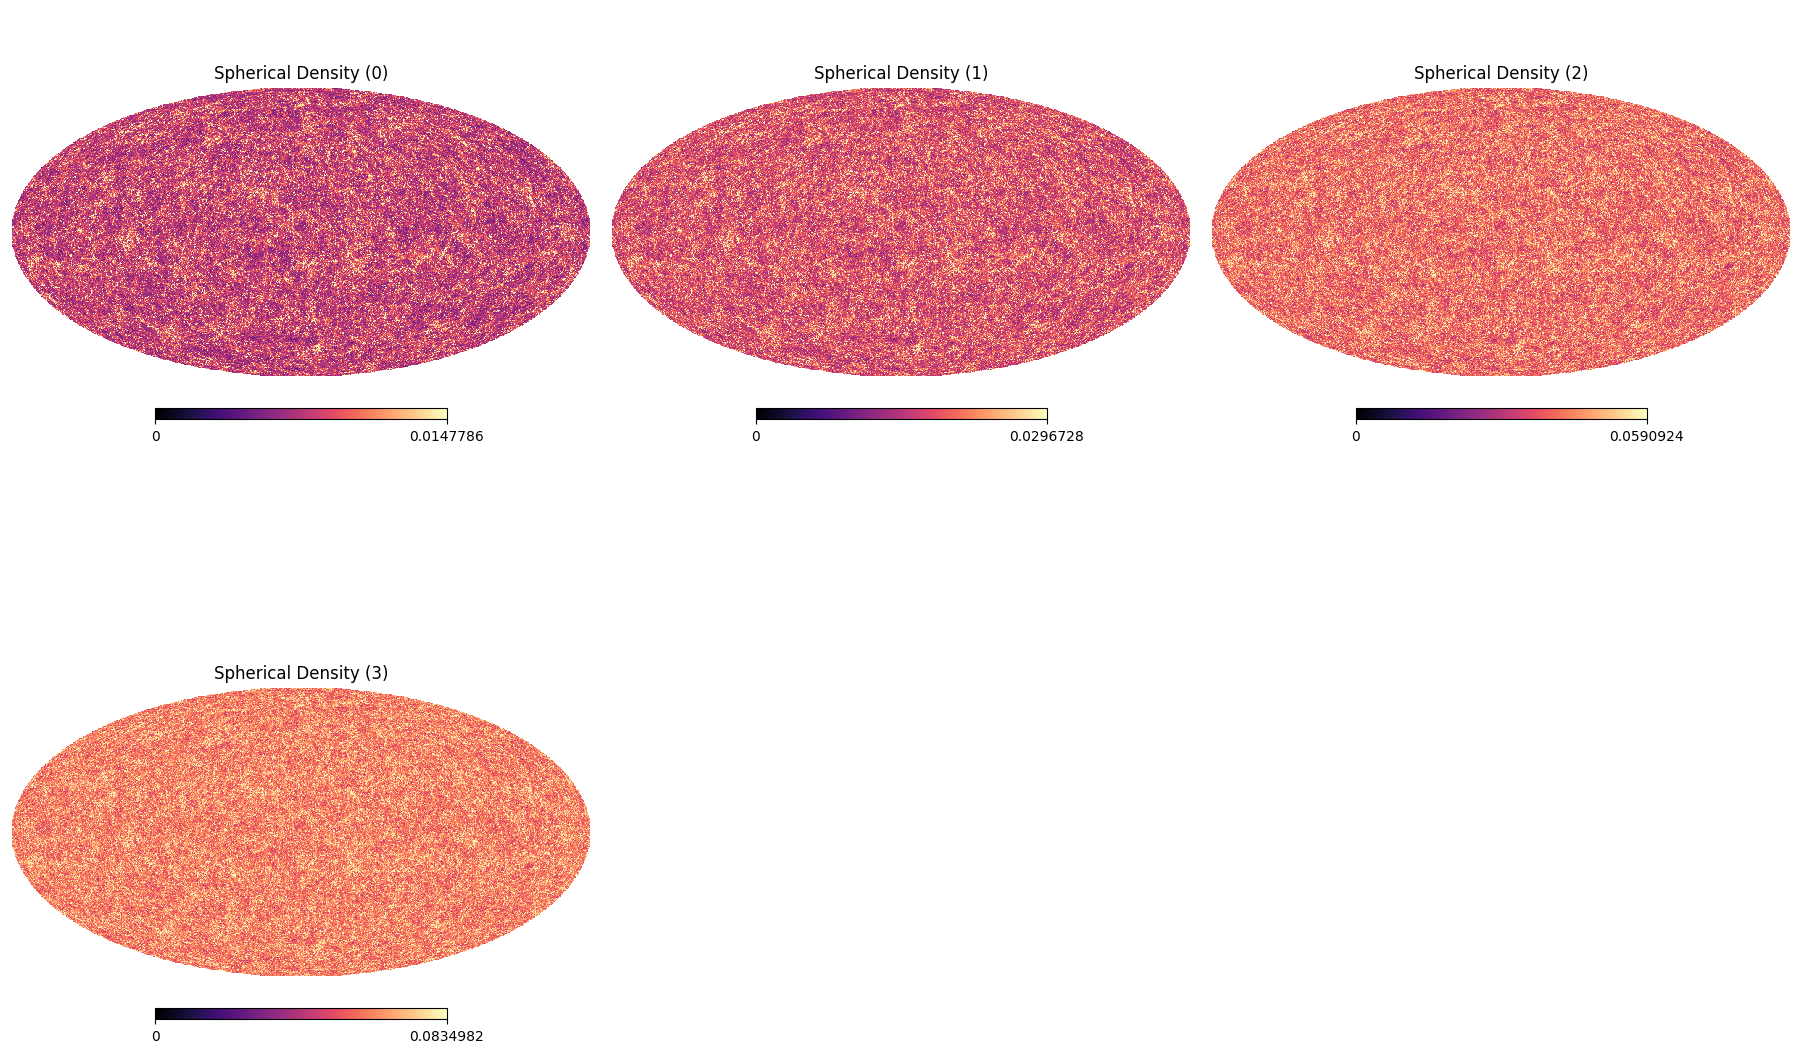

In [6]:
stage3_path = "/home/wassim/Projects/NBody/Simulations/CosmoGrid/stage3_forecast/cosmo_000001/perm_0000/"
stage3_catalog = ffi.io.load_cosmogrid_kappa(stage3_path, cosmology=cosmogrid_catalog)

print(f"Stage 3 Field shape: {stage3_catalog.field.shape}")
print(f"Stage 3 Field unit: {stage3_catalog.field.unit}")

stage3_catalog.field.show()

In [21]:
stage3_catalog.to_parquet("par.parquet")
reloaded = ffi.io.Catalog.from_parquet("par.parquet")
import jax
def tree_allclose(tree1 , tree2):
    return jax.tree_util.tree_all(jax.tree_util.tree_map(lambda x, y: jnp.allclose(x, y), tree1, tree2))

print("Original vs reloaded field allclose:", tree_allclose(stage3_catalog, reloaded))

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Generating train split: 0 examples [00:00, ? examples/s]

/home/wassim/Projects/NBody/fwd_model_tools/src/fwd_model_tools/io/catalog.py:364: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  return Catalog(field=field, cosmology=cosmology, version=item["version"])
/home/wassim/Projects/NBody/fwd_model_tools/src/fwd_model_tools/io/catalog.py:508: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  return cls(field=stacked_field, cosmology=catalogs[0].cosmology, version=catalogs[0].version)


ValueError: Mismatch custom node data: {'zmax': 5.0, 'bw': 0.01} != {'zmax': 5.0, 'bw': 0.009999999776482582}; value: (Array([[0.        , 0.005005  , 0.01001001, ..., 4.98998976, 4.99499512,
        5.        ],
       [0.        , 0.005005  , 0.01001001, ..., 4.98998976, 4.99499512,
        5.        ],
       [0.        , 0.005005  , 0.01001001, ..., 4.98998976, 4.99499512,
        5.        ],
       [0.        , 0.005005  , 0.01001001, ..., 4.98998976, 4.99499512,
        5.        ]], dtype=float64), Array([[0.00000000e+00, 4.84462176e-03, 1.90658830e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.73315846e-06, 1.90678038e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 9.12062851e-13, 5.95623828e-11, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.96913232e-08, 3.43406157e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]], dtype=float64)).

## Loading GowerStreet Data

GowerStreet stores per-step lightcone `.npy` files with a `control.par` for cosmology
and `z_values.txt` for shell metadata.

In [7]:
gowerstreet_path = Path("/home/wassim/Projects/NBody/Simulations/GowerStreet/sim00001/")

gowerstreet_catalog = ffi.io.load_gowerstreet(gowerstreet_path, max_shells=10, ud_nside=512)

print(f"Field shape:  {gowerstreet_catalog.field.shape}")
print(f"Field nside:  {gowerstreet_catalog.field.nside}")
print(f"Field status: {gowerstreet_catalog.field.status}")
print(f"Field unit:   {gowerstreet_catalog.field.unit}")

[(100,), (100,), (100,), (100,), (100,)]
[(10,), (10,), (10,), (10,), (100,)]
Field shape:  (10, 3145728)
Field nside:  512
Field status: FieldStatus.LIGHTCONE
Field unit:   DensityUnit.COUNTS


In [8]:
cosmo_gs = gowerstreet_catalog.cosmology

print(f"Omega_c: {cosmo_gs.Omega_c:.4f}")
print(f"Omega_b: {cosmo_gs.Omega_b:.4f}")
print(f"h:       {cosmo_gs.h:.4f}")
print(f"sigma8:  {cosmo_gs.sigma8:.4f}")
print(f"n_s:     {cosmo_gs.n_s:.4f}")
print(f"w0:      {cosmo_gs.w0:.4f}")

Omega_c: 0.2410
Omega_b: 0.0490
h:       0.6674
sigma8:  0.7658
n_s:     0.9497
w0:      -1.0089


In [9]:
field_gs = gowerstreet_catalog.field

print(f"Scale factors:          {np.asarray(field_gs.scale_factors).flatten()[:5]} ...")
print(f"Comoving centers (Mpc/h): {np.asarray(field_gs.comoving_centers).flatten()[:5]} ...")
print(f"Shell widths (Mpc/h):   {np.asarray(field_gs.density_width).flatten()[:5]} ...")

Scale factors:          [0.91003735 0.91929931 0.92860728 0.93796224 0.94736533] ...
Comoving centers (Mpc/h): [152.915597  136.93379   121.111526  105.4464735  89.936396 ] ...
Shell widths (Mpc/h):   [273.856594 242.212231 210.882287 179.862288 149.147387] ...


In [10]:
gowerstreet_catalog.field.shape

(10, 3145728)

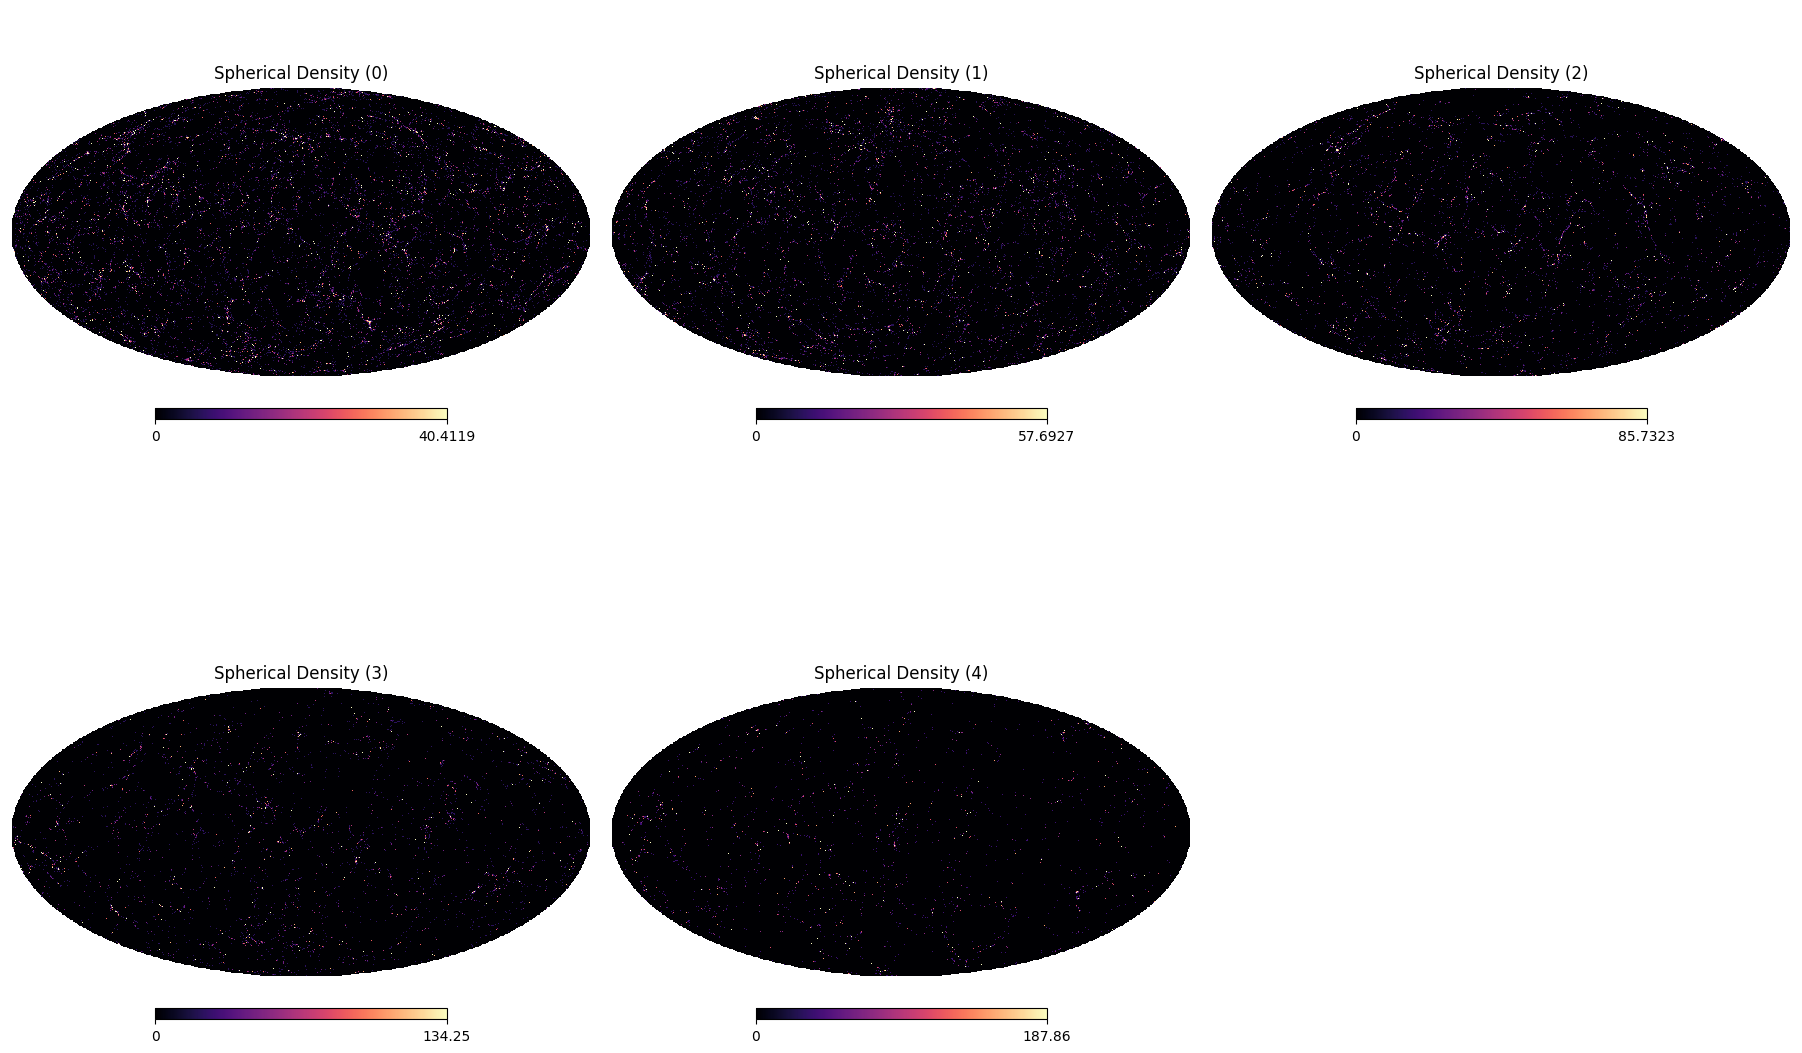

In [11]:
gowerstreet_catalog.field[:5].to(ffi.DensityUnit.OVERDENSITY).show()

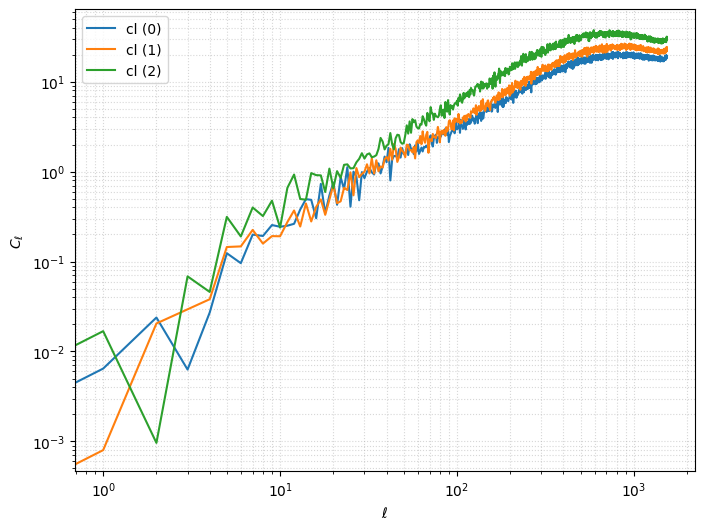

(<Figure size 800x600 with 1 Axes>,
 <Axes: xlabel='$\\ell$', ylabel='$C_\\ell$'>,
  <matplotlib.lines.Line2D at 0x729030332c50>])

In [12]:
cl = gowerstreet_catalog.field[:3].to(ffi.DensityUnit.OVERDENSITY).angular_cl(method="healpy")
cl = cl.apply_fn(lambda x: x * cl.wavenumber * (cl.wavenumber + 1) / (2 * np.pi))
cl.show()